In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

Loaded dataset: 1653 rows, 14 columns
Clean numeric dataset shape: (1653, 14)
    latitude   longitude  avg_distance_km  avg_visibility_mi  avg_temp_F  \
0  31.676631 -106.323587         0.561889           9.772388   72.241045   
1  31.676631 -106.323587         0.561889           9.772388   72.241045   
2  31.676631 -106.323587         0.561889           9.772388   72.241045   

   avg_wind_mph  
0      8.430159  
1      8.430159  
2      8.430159  
Array dtype: float32 | shape: (1653, 6)
Sample row: [  31.676632   -106.323586      0.56188947    9.772388     72.24104
    8.430159  ]

Running KMeans clustering


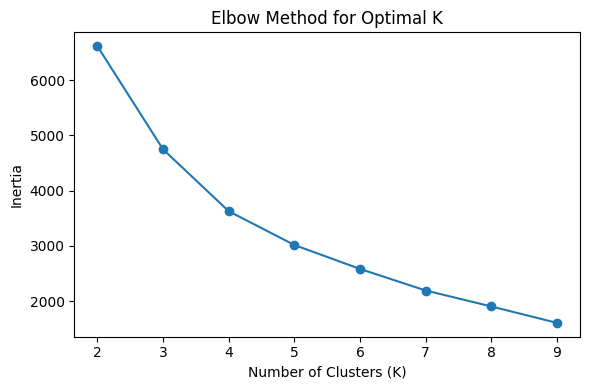

kmeans_cluster
2    788
1    538
0    233
3     94
Name: count, dtype: int64


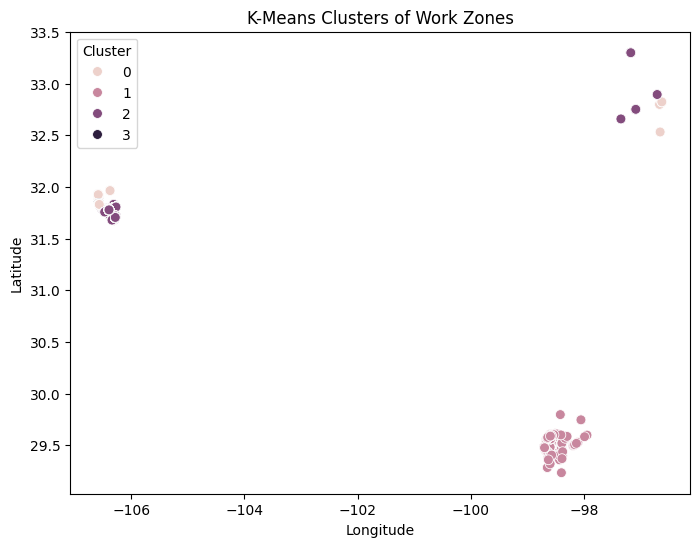


Running DBSCAN clustering
DBSCAN found 31 clusters and 49 noise points.
/tmp/ipykernel_2058/3645909254.py:75: UserWarning: 
The palette list has fewer values (10) than needed (32) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


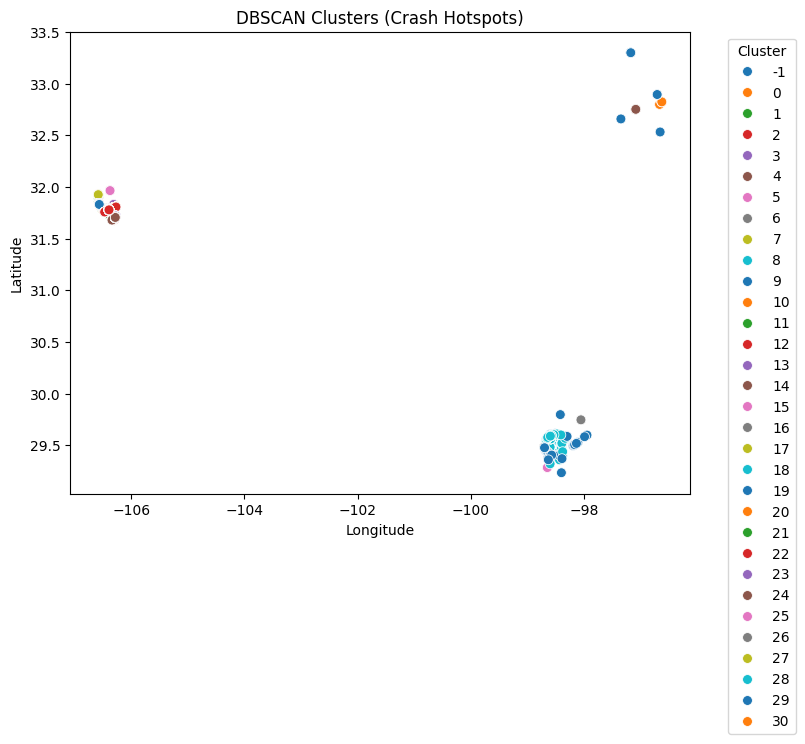


Cluster summaries

KMeans summary:
                 latitude  longitude  avg_distance_km  avg_visibility_mi  \
kmeans_cluster                                                            
0                  31.95    -106.09             0.44               8.77   
1                  29.55     -98.54             0.43               9.26   
2                  31.80    -106.08             0.49               9.80   
3                  31.87    -106.58             0.61              10.00   

                avg_temp_F  avg_wind_mph  
kmeans_cluster                            
0                    57.50          7.42  
1                    70.48          8.52  
2                    70.98          9.13  
3                    78.75          4.50  

DBSCAN summary:
                 latitude  longitude  avg_distance_km  avg_visibility_mi  \
dbscan_cluster                                                            
0                  31.68    -106.32             0.56               9.77   
1          

In [2]:
#Unsupervised Clustering (KMeans / DBSCAN)

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

# Load data
df = pd.read_csv("/work/siads_699_mads_capstone/data/models/workzone_features.csv")
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# Features for clustering
features = ["latitude", "longitude", "avg_distance_km",
    "avg_visibility_mi", "avg_temp_F", "avg_wind_mph"]

for col in features:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r"[^\d\.\-Ee]", "", regex=True)  
        .str.replace("−", "-", regex=False)           
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=features)
print("Clean numeric dataset shape:", df.shape)
print(df[features].head(3))

X = df[features].to_numpy(dtype=np.float32)
print("Array dtype:", X.dtype, "| shape:", X.shape)
print("Sample row:", X[0])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#KMeans clustering
print("\nRunning KMeans clustering")
inertias = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
plt.figure(figsize=(6, 4))
plt.plot(K, inertias, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)
print(df["kmeans_cluster"].value_counts())

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, x="longitude", y="latitude",
    hue="kmeans_cluster",  s=50
)
plt.title("K-Means Clusters of Work Zones")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()

#DBSCAN clustering
print("\nRunning DBSCAN clustering")
db = DBSCAN(eps=0.5, min_samples=5)
df["dbscan_cluster"] = db.fit_predict(X_scaled)
unique_labels = np.unique(df["dbscan_cluster"])
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = np.sum(df["dbscan_cluster"] == -1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, x="longitude", y="latitude",
    hue="dbscan_cluster", palette=sns.color_palette("tab10", 10), s=50
)
plt.title("DBSCAN Clusters (Crash Hotspots)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#Summary
print("\nCluster summaries")
kmeans_summary = df.groupby("kmeans_cluster")[features].mean().round(2)
dbscan_summary = (
    df[df["dbscan_cluster"] != -1]
    .groupby("dbscan_cluster")[features]
    .mean()
    .round(2)
)
print("\nKMeans summary:\n", kmeans_summary)
print("\nDBSCAN summary:\n", dbscan_summary)

out_path = "/work/siads_699_mads_capstone/data/models/workzone_features_clustered.csv"
df.to_csv(out_path, index=False)
print(f"\nSaved clustered dataset to {out_path}")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>